# Chainer の応用

前章で説明した Chainer を用いてネットワークを訓練するまでに必要なステップは、以下の 5 つでした。

- Step 1：データセットの準備
- Step 2：ネットワークの定義
- Step 3：目的関数を決める
- Step 4：最適化手法の選択
- Step 5：ネットワークの訓練

本章では、これらの各ステップに対して Chainer の機能を活用した工夫を加え、結果を改善する方法を解説します。

## Step 1 の改善: データセットの準備の工夫

前章で用いた iris データセットは、ndarray のままスライスを用いてミニバッチに分割し、ネットワークに入力したり、誤差の計算に用いたりしていました。
ここでは、Chainer が提供するいくつかのデータセットを扱うためのクラスを用いて同様のことを行ってみます。

まずはデータセットを scikit-learn を用いて取得しておきます。

In [0]:
from sklearn.datasets import load_iris

x, t = load_iris(return_X_y=True)
x = x.astype('float32')
t = t.astype('int32')

### TupleDataset

Chainer は `chainer.datasets` モジュール以下に色々なデータセットに対して用いられる便利なクラスが用意されています。
その一つが `TupleDataset` で、これは上で取得したような入力値を並べた配列と目標値を並べた配列を与えると、1 つ 1 つを取り出して対応するペアを作って返してくれるものです。

In [0]:
from chainer.datasets import TupleDataset

dataset = TupleDataset(x, t)

Chainer が提供する汎用のデータセットクラスは、ndarray をデータセットとして扱う場合と同様にして使えるよう、`[]` を使ったインデックスによる各データ（入力値と目標値のペタ）へのアクセスを可能としています。

それでは、1 つ目の入力値と目標値のペアを取り出してみます。

In [3]:
dataset[0]

(array([5.1, 3.5, 1.4, 0.2], dtype=float32), 0)

入力値と目標値を 1 つずつ持つタプルが返されました。
それでは、2 つのデータを取り出してみます。

In [4]:
dataset[:2]

[(array([5.1, 3.5, 1.4, 0.2], dtype=float32), 0),
 (array([4.9, 3. , 1.4, 0.2], dtype=float32), 0)]

`(入力値, 目標値)` というタプルを 2 つ持つリストが返されました。
このように、Python のリストで用いることができるスライスと同様の表記を Chainer のデータセットオブジェクトに対して用いることができます。

例えば、先頭から 1 つおきに 5 つのデータを取り出したい場合、

In [5]:
dataset[:10:2]

[(array([5.1, 3.5, 1.4, 0.2], dtype=float32), 0),
 (array([4.7, 3.2, 1.3, 0.2], dtype=float32), 0),
 (array([5. , 3.6, 1.4, 0.2], dtype=float32), 0),
 (array([4.6, 3.4, 1.4, 0.3], dtype=float32), 0),
 (array([4.4, 2.9, 1.4, 0.2], dtype=float32), 0)]

のような記述が可能です。

### データセットの分割

データセットを訓練用・検証用・テスト用に分割するのに便利な関数が Chainer にも用意されています。
これを用いて先程読み込んだ Iris データセットを 3 つに分割してみます。

In [0]:
from chainer.datasets import split_dataset_random

train_val, test = split_dataset_random(dataset, int(len(dataset) * 0.7), seed=0)
train, valid = split_dataset_random(train_val, int(len(train_val) * 0.7), seed=0)

`dataset` の中のデータのうち 70% を `train_val` に、残りを `test` にランダムに振り分け、さらに `train_test` のうち 70% を `train` に、残りを `valid` にランダムに振り分けています。

### SerialIterator

前章では、訓練データセットの順番を毎エポックシャッフルする方法として `np.random.permutation()` 関数が用いられていましたが、Chainer ではこのようなネットワークの訓練に際してよく行われるデータセットへの操作を抽象化した Iterator が提供されています。

Iteratorは、データセットオブジェクトを与えると、順番のシャッフルやバッチサイズ個だけデータをまとめて返すなどの操作を自動的に行なってくれるものです。
Python のイテレータと似たインターフェースを持ち、`next()` メソッドで順番にミニバッチを返してくれ、1 エポックが終了したら自動的にデータの順番をシャッフルしなおしてくれる便利なものです。

ここでは最もシンプルな Iterator である `SerialIterator` を紹介します。

In [7]:
from chainer.iterators import SerialIterator

train_iter = SerialIterator(train, batch_size=4, repeat=True, shuffle=True)

minibatch = train_iter.next()

minibatch

[(array([5.7, 3. , 4.2, 1.2], dtype=float32), 1),
 (array([6.4, 3.1, 5.5, 1.8], dtype=float32), 2),
 (array([4.8, 3. , 1.4, 0.3], dtype=float32), 0),
 (array([6. , 2.2, 5. , 1.5], dtype=float32), 2)]

上のコードは、iris データセットを分割して作成した訓練用データセット train を渡して作成した SerialIterator から、最初のミニバッチを取り出す例です。

インスタンス化の際に引数として `batchsize=4` を指定しているため、返ってきたミニバッチには 4 つのデータが格納されていることが分かります。

`repeat` 引数には、`next()` を繰り返し実行してデータセット内の全てのデータを取り出し終えたあとに、次の `next()` の呼び出しに対してまたデータセットの先頭からデータを取り出して次のミニバッチを返すかどうかを指定します。
1 エポック以上訓練を行う場合は訓練データセット内のデータを複数回用いるので、これを `True` にします。

`shuffle` 引数には、データセット内のデータの順番をエポックごとに自動的にシャッフルするかどうかを指定します。

## Step 2 の改善: ネットワーク構造の工夫

前章ではネットワークを Sequential クラスを用いて定義しました。
ここでは Chain クラスを継承してネットワークを定義する方法を説明します。

### Chain

Link を複数まとめて Chain というまとまりを作ることが出来ます。
Chain クラスは Link クラスを継承しており、前章で解説した Link と同様に扱うことができます。
ただし、内部に複数の Link を保持しておくことができ、呼び出されたときに実行される巡伝播計算を `forward()` メソッドに記述しておくことで、複数の Link や Function を組み合わせた独自の層を作るのに使うことができます。
また、ネットワークの部分構造を記述したり、それ自体で 1 つのネットワークの定義とすることもできます。

それでは、前章で定義した Linear 層を 3 つ持つネットワークと同じものを Chain クラスを継承した `Net` というクラスを作って定義してみましょう。

In [0]:
import chainer
import chainer.links as L
import chainer.functions as F


class Net(chainer.Chain):
    
    def __init__(self, n_in=4, n_hidden=3, n_out=3):
        super().__init__()
        with self.init_scope():
            self.l1 = L.Linear(n_in, n_hidden)
            self.l2 = L.Linear(n_hidden, n_hidden)
            self.l3 = L.Linear(n_hidden, n_out)

    def forward(self, x):
        h = F.relu(self.l1(x))
        h = F.relu(self.l2(h))
        h = self.l3(h)
        
        return h

net = Net()

この Net クラスは 3 層の全結合型ニューラルネットワークを表しています。

`__init__()` メソッドでは、`init_scope()` によって作られるコンテキストの中で Linear 層 を 3 つ作成し、それぞれ別々の名前の属性に代入しています。
このコンテキストの中で属性に代入された Link が持つパラメータは、Optimizer によるパラメータ更新の対象として登録されます。
このコンテキストの外で Link を作成し属性に代入を行っても、その Link が持つパラメータは Optimizer によるパラメータ更新の対象にならないため、注意が必要です。

`init_scope()` コンテキストの中で定義されている Linear クラスのインスタンス化の際には `n_in`、`n_hidden`、`n_out` などの Net クラスの `__init__()` メソッドがとる引数が使われています。
こうすることで Net クラスをインスタンス化する際に内部の Linear 層のパラメータ数などを変更することができます。
例えば、`self.l1` の出力ノード数を 100 にするには、以下のようにします。

In [0]:
net = Net(n_hidden=100)

このように、Chain を継承したクラスを用いてネットワークを定義すると、インスタンス化の際に各層の出力ノード数などを変更することができ、より柔軟性とコードの再利用性が高まります。

## Step 3 の改善: 目的関数の工夫

前章では、分類問題を解くために `F.softmax_cross_entorpy` という目的関数を使用しました。
これはネットワークの出力を ${\bf y}$ とおくと、以下のような式で表される計算を行っています。

$$
\begin{align}
\hat{\bf y} &= {\rm softmax}({\bf y}) \\
L(\boldsymbol\Theta) &= \sum_{k=1}^K \hat{y}_k \log t_k
\end{align}
$$

ただし、$\hat{y}_k, t_k$ はそれぞれ $\hat{\bf y}$ の $k$ 番目の要素と、1-hotベクトル表現されたクラスラベルを表す目的変数 ${\bf t}$ の $k$ 番目の要素をそれぞれ表しています。
また、$\boldsymbol\Theta$ はネットワークが持つ全パラメータを指します。

ここで、この目的関数に**正則化項 (regularization term)** を追加してみましょう。
**正則化 (regularization)** とは、過学習を防ぐために、目的関数に新たな項を追加して、モデルの複雑さに罰則を科したり、パラメータのノルムの大きさに罰則をかけたりすることを指します。
そのために目的関数に追加される項が正則化項です。

ここでは、**重み減衰 (weight decay)** と呼ばれる正則化を適用してみましょう。
これは、**L2正則化 (L2 regularization)** とも呼ばれます。
重み減衰を行う場合、最適化する目的関数は以下になります。

$$
L(\boldsymbol\Theta) + \lambda \frac{1}{2} \sum_w || w ||^2
$$

ここで、$w$ はネットワークのパラメータを指し、上式の第 2 項は全てのパラメータの値を二乗したものの総和を取り、2 で割るという計算を意味します。
この項を目的関数に加えると、ネットワークの重みの絶対値が大きくなりすぎないようにする効果があり、過学習を防ぐために役立ちます。
$\lambda$ は正則化の強さをコントロールします。
新しい目的関数を用いる場合のパラメータの更新式は一般に以下となります。

$$
w \leftarrow w - \eta \left( \frac{\partial L(\boldsymbol\Theta)}{\partial w} + \lambda w \right)
$$

ここで、$\eta$ は学習率を表します。
この式から、パラメータ更新の際にパラメータ自身の更新前の値に $\lambda$ を乗じたものを更新量に加えればよいということが分かります。
重み減衰はバイアスの更新式には通常適用しないことに注意してください[<sup>*1</sup>](#no_weight_decay_for_bias]。

Chainer は、パラメータを更新する際に更新計算をカスタマイズする方法を 2 種類提供しています。

1 つは、ネットワークが持つパラメータ全てに対して一様に、更新時にある処理を行いたい場合に使える、Optimizer hook という機能です。
これは、Optimizer オブジェクトの `add_hook()` メソッドに更新時に全パラメータに対して行いたい処理を記述した関数を渡して使用します。

もう 1 つは、パラメータごとに別々に処理を行いたい場合に使える方法で、ネットワークのパラメータが持っている UpdateRule というオブジェクトにフック関数を追加します。
全ての訓練可能なパラメータは、Optimizer オブジェクトの `setup()` メソッドに渡された際に `update_rule` という属性に UpdateRule オブジェクトがセットされます。
この UpdateRule オブジェクトは、最適化手法によって異なる更新ルールが記述されたもので、`add_hook()` メソッドを持ち、ここに Optimizer hook または任意の関数を追加することができます。
これを用いると、更新時にパラメータごとに別の関数を読んで更新計算をカスタマイズすることができます。
重み減衰は、前述のようにバイアスには適用しないため、今回は UpdateRule に対してフック関数を追加します。

Chainer では、`chainer.optimizer_hooks` モジュール以下に数種類の正則化手法が定義されており、重み減衰は `WeightDecay` というクラスとして定義されています。それでは、これを用いて前章と同様に最適化手法として SGD を採用しつつ、新たに重み減衰を適用するような `optimizer` を定義しましょう。

In [0]:
from chainer import optimizers
from chainer.optimizer_hooks import WeightDecay

optimizer = optimizers.SGD(lr=0.001)  # 学習率を 0.01 に設定
optimizer.setup(net)

for param in net.params():
    if param.name != 'b':  # バイアス以外だったら
        param.update_rule.add_hook(WeightDecay(0.0001))  # 重み減衰を適用

ネットワークの持つパラメータは、Chain クラスの `params()` メソッドを使って取得することができます。
また、Linear クラスの中でバイアスは `b` という名前で定義されているため、各パラメータの名前をチェックして `b` という名前**でない**場合にだけ WeightDecay を UpdateRule にフック関数として追加しています。
WeightDecay クラスはインスタンス化時に引数を 1 つとり、前述の $\lambda$ に対応する係数を指定することができます。
ここでは、`0.0001` を指定しています。

## Step 4 の改善: 最適化手法の工夫

前章では、Chainer が提供している最もシンプルな最適化手法の一つである SGD を用いていました。

Chainer は SGD の他にも多くの最適化手法を提供しています。
ここでは、その中でも代表的な手法の一つである MomentumSGD という手法を用いるように変更を加えてみましょう。

MomentumSGD は SGD の改良版で、パラメータ更新の際に**前回の更新量**を使って更新方向がスムーズになるように工夫するもので、更新式は以下になります。

$$
\Delta w_t = \frac{\partial L(\boldsymbol\Theta)}{\partial w^{(t)}} \\
w \leftarrow w - \eta \Delta x_{t} + \mu \Delta x_{t - 1}
$$

ここで、$t$ 回目の更新量を $\Delta x_t$ とおいています。
また、$\mu$ は前回更新量に掛ける係数で、多くの場合 $0.9$ 程度が用いられます。
これを前節で解説した重み減衰と合わせて用いると、更新式は以下のようになります。

$$
w \leftarrow w - \eta \Delta x_{t} + \mu \Delta x_{t - 1} - \eta \lambda w
$$

それでは、MomentumSGD に加えて重み減衰を用いる Optimizer を定義してみましょう。

In [0]:
from chainer import optimizers
from chainer.optimizer_hooks import WeightDecay

optimizer = optimizers.MomentumSGD(lr=0.001, momentum=0.9)
optimizer.setup(net)

for param in net.params():
    if param.name != 'b':  # バイアス以外だったら
        param.update_rule.add_hook(WeightDecay(0.0001))  # 重み減衰を適用

## Step 5 の改善：ネットワークの訓練における工夫

最後に、ネットワークの訓練を高速化するために GPU を用いる方法を紹介します。

Iris データセットはデータ数が少なく、各データの次元数も小さい上に、前章では訓練したニューラルネットワークのパラメータ数も多くありませんでした。
そのため、CPU を使ってもそこまで長く待たされることなく訓練が終了しました。

しかし、より大きなデータセットを使い、より多くの層を持つニューラルネットワークを訓練しようとすると、CPU だけでは膨大な時間がかかってしまいます。
そこで、GPU を使って計算を高速化する必要が出てきます。

まず、GPU が使える環境であることを確認しましょう。
こちらを参考に GPU を有効にしてください。参考：[GPU を使用する](01_Welcome_to_Chainer_Tutorial_ja.html#GPU-%E3%82%92%E4%BD%BF%E7%94%A8%E3%81%99%E3%82%8B)

また、一台のマシンに複数の GPU を挿して用いる場合もあるため、GPU を用いる際はデバイス ID というものを意識する必要がありますが、Google Colaboratory では利用できる GPU が 1 枚だけなので、このデバイス ID としては基本的に 0 を指定すれば良いことになります。

GPU を利用したい場合、ネットワークの訓練を開始する前に気をつけることは主に以下の 2 つです。

- ネットワークを `to_gpu()` を用いて GPU メモリ上に転送しておく
- ネットワークに入力するデータを CuPy の ndarray に変換しておく

それでは、訓練ループを GPU を使用する形に変更してみましょう。

In [12]:
gpu_id = 0  # 使用する GPU 番号
n_batch = 64  # バッチサイズ
n_epoch = 50  # エポック数

# ネットワークを GPU メモリ上に転送
net.to_gpu(gpu_id)

# ログ
results_train, results_valid = {}, {}
results_train['loss'], results_train['accuracy'] = [], []
results_valid['loss'], results_valid['accuracy'] = [], []

train_iter.reset()  # 上で一度 next() が呼ばれているため

count = 1

for epoch in range(n_epoch):
    
    while True:
        
        # ミニバッチの取得
        train_batch = train_iter.next()
        
        # x と t に分割
        # データを GPU に転送するために、concat_examples に gpu_id を渡す
        x_train, t_train = chainer.dataset.concat_examples(train_batch, gpu_id)

        # 予測値と目的関数の計算
        y_train = net(x_train)
        loss_train = F.softmax_cross_entropy(y_train, t_train)
        acc_train = F.accuracy(y_train, t_train)

        # 勾配の初期化と勾配の計算
        net.cleargrads()
        loss_train.backward()

        # パラメータの更新
        optimizer.update()
    
        # カウントアップ
        count += 1

        # 1エポック終えたら、valid データで評価する
        if train_iter.is_new_epoch:

            # 検証用データに対する結果の確認
            with chainer.using_config('train', False), chainer.using_config('enable_backprop', False):
                x_valid, t_valid = chainer.dataset.concat_examples(valid, gpu_id)
                y_valid = net(x_valid)
                loss_valid = F.softmax_cross_entropy(y_valid, t_valid)
                acc_valid = F.accuracy(y_valid, t_valid)
            
            # 注意：GPU で計算した結果はGPU上に存在するため、CPU上に転送します
            loss_train.to_cpu()
            loss_valid.to_cpu()
            acc_train.to_cpu()
            acc_valid.to_cpu()

            # 結果の表示
            print('epoch: {}, iteration: {}, loss (train): {:.4f}, loss (valid): {:.4f}'
                  'acc (train): {:.4f}, acc (valid): {:.4f}'.format(
                epoch, count, loss_train.array.mean(), loss_valid.array.mean(),
                  acc_train.array.mean(), acc_valid.array.mean()))

            # 可視化用に保存
            results_train['loss'] .append(loss_train.array)
            results_train['accuracy'] .append(acc_train.array)
            results_valid['loss'].append(loss_valid.array)
            results_valid['accuracy'].append(acc_valid.array)
            
            break

epoch: 0, iteration: 20, loss (train): 0.5593, loss (valid): 1.1641acc (train): 0.7500, acc (valid): 0.2812
epoch: 1, iteration: 38, loss (train): 0.5643, loss (valid): 0.6651acc (train): 0.7500, acc (valid): 0.6562
epoch: 2, iteration: 56, loss (train): 0.6048, loss (valid): 0.4401acc (train): 0.5000, acc (valid): 0.9375
epoch: 3, iteration: 74, loss (train): 0.4558, loss (valid): 0.3911acc (train): 1.0000, acc (valid): 0.9062
epoch: 4, iteration: 93, loss (train): 0.5761, loss (valid): 0.3446acc (train): 0.7500, acc (valid): 0.9375
epoch: 5, iteration: 111, loss (train): 0.3042, loss (valid): 0.3256acc (train): 0.7500, acc (valid): 0.9062
epoch: 6, iteration: 129, loss (train): 0.5116, loss (valid): 0.2832acc (train): 0.7500, acc (valid): 0.9688
epoch: 7, iteration: 147, loss (train): 0.2061, loss (valid): 0.2661acc (train): 1.0000, acc (valid): 0.9688
epoch: 8, iteration: 166, loss (train): 0.2615, loss (valid): 0.2774acc (train): 1.0000, acc (valid): 0.9062
epoch: 9, iteration: 184

GPU を用いて訓練することができました。

前章で CPU を用いて訓練を行ったとき同様に、損失と精度が訓練が進むにつれてどのように変化していったかを確認してみましょう。

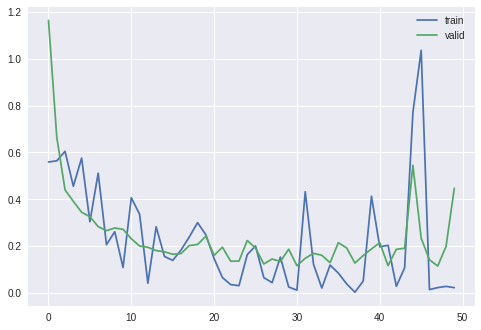

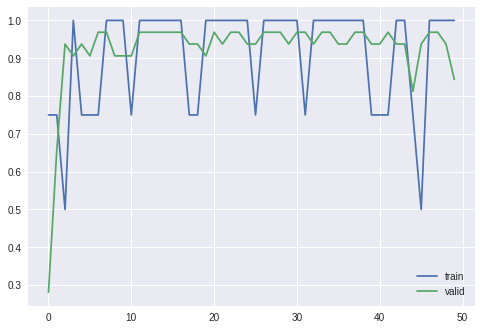

In [13]:
import matplotlib.pyplot as plt

# 損失 (loss)
plt.plot(results_train['loss'], label='train')  # label で凡例の設定
plt.plot(results_valid['loss'], label='valid')  # label で凡例の設定
plt.legend()  # 凡例の表示
plt.show()

# 精度 (accuracy)
plt.plot(results_train['accuracy'], label='train')  # label で凡例の設定
plt.plot(results_valid['accuracy'], label='valid')  # label で凡例の設定
plt.legend()  # 凡例の表示
plt.show()

テストデータに対する評価も行ってみましょう。

In [14]:
# テストデータに対する損失と精度を計算
x_test, t_test = chainer.dataset.concat_examples(test, device=gpu_id)
with chainer.using_config('train', False), chainer.using_config('enable_backprop', False):
    y_test = net(x_test)
    loss_test = F.softmax_cross_entropy(y_test, t_test)
    acc_test = F.accuracy(y_test, t_test)

print('test loss: {:.4f}'.format(loss_test.array.get()))
print('test accuracy: {:.4f}'.format(acc_test.array.get()))

test loss: 0.3595
test accuracy: 0.8889


### GPU を用いて訓練したネットワークの保存

訓練に GPU を用いた場合は、`save_npz()` 関数を使ったネットワーク重みの保存の際に、まずネットワークのパラメータを CPU メモリ上に転送することを忘れないでください。

In [0]:
from chainer.serializers import save_npz

net.to_cpu()

save_npz('net.npz', net)

正常に保存できているかどうか、読み込んで確認してみます。

In [16]:
import numpy as np

params = np.load('net.npz')

for key, param in params.items():
    print(key, ':\t', param.shape)

l2/W :	 (100, 100)
l2/b :	 (100,)
l3/W :	 (3, 100)
l3/b :	 (3,)
l1/W :	 (100, 4)
l1/b :	 (100,)


<hr />
<span id="no_weight_decay_for_bias"><sup>*1</sup> : <small>
    重み減衰をバイアスに適用することは、大抵最終的なネットワークの訓練結果に小さな違いしかもたらしません。（参考：[Backpropagation Algorithm](http://deeplearning.stanford.edu/wiki/index.php/Backpropagation_Algorithm)）
    </small></span>